In [1]:
import tensorflow as tf
from NetworkLayer import *
from WeightInit import WeightInit
from MITOS12Data import MITOS12Data
from matplotlib import pyplot as plt
import numpy as np
from sys import stdout
import os

from Network import Network

In [2]:
autoEncoderModel = {
    'inputLayer' : ImageInputLayer(width=64,height=64,channels=3),
    'hiddenLayers' : [
        ConvolutionLayer(kernelsize=5, channels=3, features=12, stride=2, weightInitFunc=WeightInit.truncatedNormal, biasInitFunc=WeightInit.positive, activationFunc=tf.nn.relu, inputshape=[64,64,3]),
        ConvolutionLayer(kernelsize=5, channels=12, features=48, stride=2,weightInitFunc=WeightInit.truncatedNormal, biasInitFunc=WeightInit.positive, activationFunc=tf.nn.relu, inputshape=[32,32,12]),
        ConvolutionLayer(kernelsize=5, channels=48, features=192, stride=2,weightInitFunc=WeightInit.truncatedNormal, biasInitFunc=WeightInit.positive, activationFunc=tf.nn.relu, inputshape=[16,16,48])
    ]
}

classifierModel = {
    'inputLayer': ImageInputLayer(width=8,height=8,channels=192),
    'hiddenLayers': [
        ImageToVectorLayer(imagesize=(8,8,192)),
        FullyConnectedLayer(inputsize=8*8*192,outputsize=200,weightInitFunc=WeightInit.truncatedNormal,biasInitFunc=WeightInit.positive,activationFunc=tf.nn.tanh),
        FullyConnectedLayer(inputsize=200,outputsize=100,weightInitFunc=WeightInit.truncatedNormal,biasInitFunc=WeightInit.positive,activationFunc=tf.nn.tanh)
        ],
    'outputLayer' : FullyConnectedLayer(inputsize=100,outputsize=2,weightInitFunc=WeightInit.truncatedNormal,biasInitFunc=WeightInit.positive,activationFunc=tf.nn.softmax)
}

batch_size = 50
autoEncoder = Network(autoEncoderModel, objective='reconstruction', batch_size=batch_size)

clf = Network(classifierModel, objective='classification', batch_size=batch_size)
clf.setupTraining("cross-entropy", "Adam")

init = tf.initialize_all_variables()
basedir = "/media/sf_E_DRIVE/Dropbox/ULB/Doctorat/ImageSet/MITOS12/"
train_dirs = [os.path.join(basedir,d) for d in ["A00_v2", "A01_v2", "A02_v2", "A03_v2", "A04_v2"]]
eval_dirs = [os.path.join(basedir, d) for d in ["A_eval/A00_v2", "A_eval/A01_v2", "A_eval/A02_v2", "A_eval/A03_v2", "A_eval/A04_v2"]]
mitos12 = MITOS12Data(train_dirs=train_dirs, eval_dirs=eval_dirs)

aesaver = tf.train.Saver(autoEncoder.getVariables())
clfsaver = tf.train.Saver(clf.getVariables())
sess = tf.Session()

{'inputLayer': <NetworkLayer.ImageInputLayer instance at 0x7f3772614680>, 'hiddenLayers': [<NetworkLayer.ConvolutionLayer instance at 0x7f37421c51b8>, <NetworkLayer.ConvolutionLayer instance at 0x7f374216bd88>, <NetworkLayer.ConvolutionLayer instance at 0x7f374210e908>]}
Tensor("Relu:0", shape=TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(12)]), dtype=float32)
Tensor("Relu_1:0", shape=TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(48)]), dtype=float32)
Tensor("Relu_2:0", shape=TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(192)]), dtype=float32)
Tensor("Relu_3:0", shape=TensorShape([Dimension(50), Dimension(16), Dimension(16), Dimension(48)]), dtype=float32)
Tensor("Relu_4:0", shape=TensorShape([Dimension(50), Dimension(32), Dimension(32), Dimension(12)]), dtype=float32)
Tensor("Relu_5:0", shape=TensorShape([Dimension(50), Dimension(64), Dimension(64), Dimension(3)]), dtype=float32)
{'inputLayer': <NetworkLayer.ImageIn

In [3]:
sess = tf.Session()

In [4]:
sess.run(init)
aesaver.restore(sess, "/home/adrien/workspace/DeepNet/mitos12ConvAutoEncoder3.ckpt")
clfsaver.restore(sess, "/home/adrien/workspace/DeepNet/mitos12ClfFromConvAutoEncoder3.ckpt")

In [74]:
evaluation_data = mitos12.get_evaluation_set()

In [76]:
print evaluation_data[0]

/media/sf_E_DRIVE/Dropbox/ULB/Doctorat/ImageSet/MITOS12/A_eval/A04_v2/A04_03


In [75]:
print len(evaluation_data[1])

40804


In [77]:
results = []
with sess.as_default():
    for t in np.arange(0,len(evaluation_data[1]),50):
        input_images = evaluation_data[1][t:t+50]
        batch_xs = autoEncoder.encode(input_images)
        pred = clf.predict(batch_xs)
        results.append(pred)

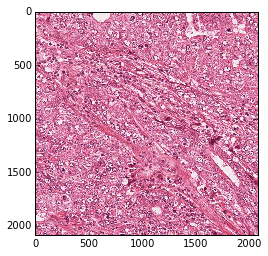

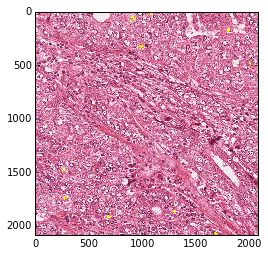

In [78]:
%matplotlib inline
from PIL import Image
im_eval = np.array(Image.open(evaluation_data[0]+".bmp"))
im_mitosis = np.array(Image.open(evaluation_data[0]+".jpg"))
plt.figure(1)
plt.imshow(im_eval)
plt.figure(2)
plt.imshow(im_mitosis)
plt.show()

In [67]:
def result_to_color(r):
    return np.array([r[0], 0, r[1]])

In [80]:
rangex = np.arange(0,np.array(im_eval).shape[0]-64,10)
rangey = np.arange(0,np.array(im_eval).shape[1]-64,10)
ts = [(t/len(rangey), t%len(rangey)) for t in range(len(rangex)*len(rangey))]
chunks = [[tx*10,ty*10] for tx,ty in ts]

(2084, 2084, 3)
0.0 49.0


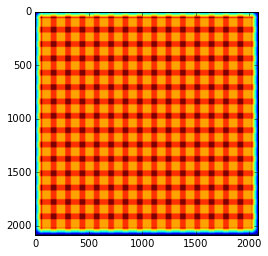

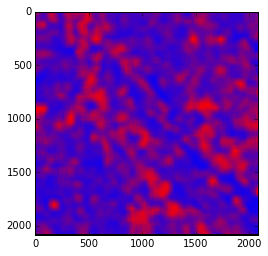

In [97]:
isMitosis_results = []
map_result = np.zeros(im_eval.shape)
map_eval = np.zeros(im_eval.shape)
map_bin = np.zeros(im_eval.shape)
print map_eval.shape

for i,r in enumerate(results):
    t = i*50
    for ii,p in enumerate(r):
        c = t+ii
        x,y = chunks[c]
        isMitosis_results.append(p.argmax())
        map_result[x:x+64,y:y+64,0] += p[0]
        map_result[x:x+64,y:y+64,1] += p[1]
        map_result[x:x+64,y:y+64,2] += 1
#        map_eval[x:x+10,y:y+10,:] = result_to_color(p)
#        map_bin[x:x+10,y:y+10,:] = p.argmax()

map_count_sup0 = map_result[:,:,2] > 0
print map_result[:,:,2].min(), map_result[:,:,2].max()
map_eval[map_count_sup0,0] = map_result[map_count_sup0,0]/map_result[map_count_sup0,2]
map_eval[map_count_sup0,2] = map_result[map_count_sup0,1]/map_result[map_count_sup0,2]
plt.imshow(map_result[:,:,2])
plt.show()
plt.imshow(map_eval)
plt.show()

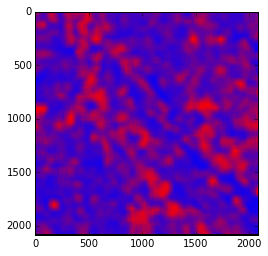

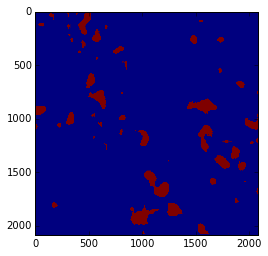

In [100]:
map_bin = map_eval[:,:,0] > 0.7
plt.imshow(map_eval)
plt.show()
plt.imshow(map_bin)
plt.show()

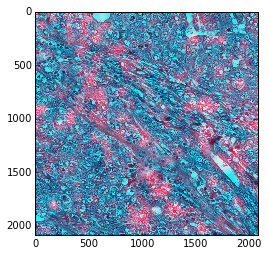

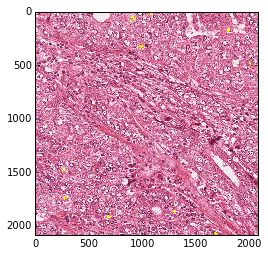

In [102]:
im_overlay = im_eval.copy()
im_overlay[:,:,0] = map_eval[:,:,0]*255
plt.imshow(im_overlay)
plt.show()
plt.imshow(im_mitosis)
plt.show()